In [ ]:
!pip install -U fsspec==2023.6.0 -q

In [ ]:
!pip install transformers datasets peft bitsandbytes accelerate torch -q

# 1. SFT (Supervised Fine‑Tuning): Случай полного дообучения

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
def tok(ex):
  return tokenizer(ex["text"], truncation=True, padding="max_length", max_length=128)
train_ds = ds.map(tok, batched=True, remove_columns=["text"])

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

Если вы смотрели первую часть семинара, то уже можете понять о чем ошибка -- токенизатор GPT-2 (gpt2) не имеет pad_token по умолчанию, потому что GPT-2 не использует padding во время обучения (он обучался на "causal" последовательностях без паддинга)

In [ ]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Если у токенизатора нет pad_token, добавим (GPT-2 его не имеет по умолчанию)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

# Загружаем датасет
ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

def tok(examples):
    # Токенизируем и создаём labels — копию input_ids для вычисления loss
    tokens = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

train_ds = ds.map(tok, batched=True, remove_columns=["text"])

In [ ]:
# на CPU в коллабе эта ячейка будет исполняться несколько суток =)

training_args = TrainingArguments(
    output_dir="sft_gpt2"
    , num_train_epochs=3
    , per_device_train_batch_size=4
    , logging_steps=50
    , save_strategy="epoch"
    , weight_decay=0.01
    , save_total_limit=2
    , report_to="none" # отключаем wandb
)

trainer = Trainer(
    model=model
    , args=training_args
    , train_dataset=train_ds
)

trainer.train()


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,1.656300


KeyboardInterrupt: 

мы не будем так долго ждать)

### Посмотрим на этого монстра

In [ ]:
!pip install torchview torchviz -q

In [ ]:
from torchviz import make_dot
import torch
from IPython.display import Image, display

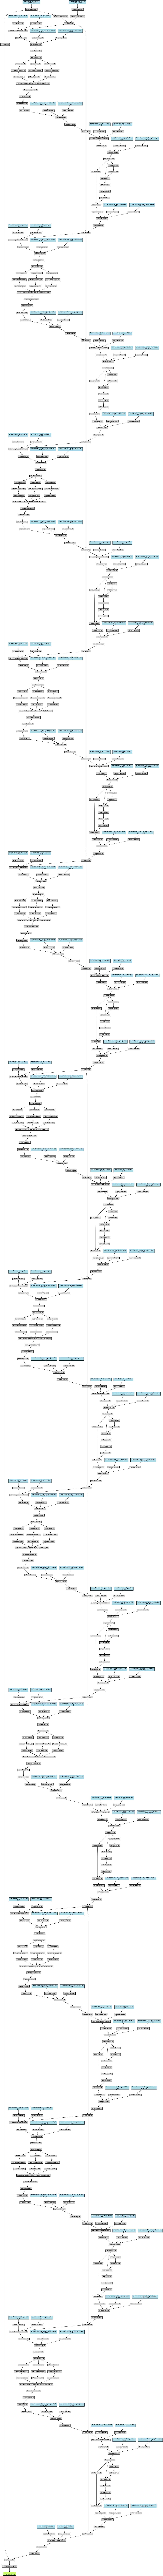

In [ ]:
model.eval()
dummy_input = torch.randint(low=0, high=model.config.vocab_size, size=(1, 10), dtype=torch.long)
outputs = model(dummy_input)
logits = outputs.logits

dot = make_dot(logits, params=dict(model.named_parameters()))
dot.render("gpt2_torchviz", format="png")
display(Image("gpt2_torchviz.png"))

### Сколько в этой модели трансформерных слоев?

In [ ]:
print(model.config.n_layer)

12


### Посмотрим как выглядит трансформерный слой

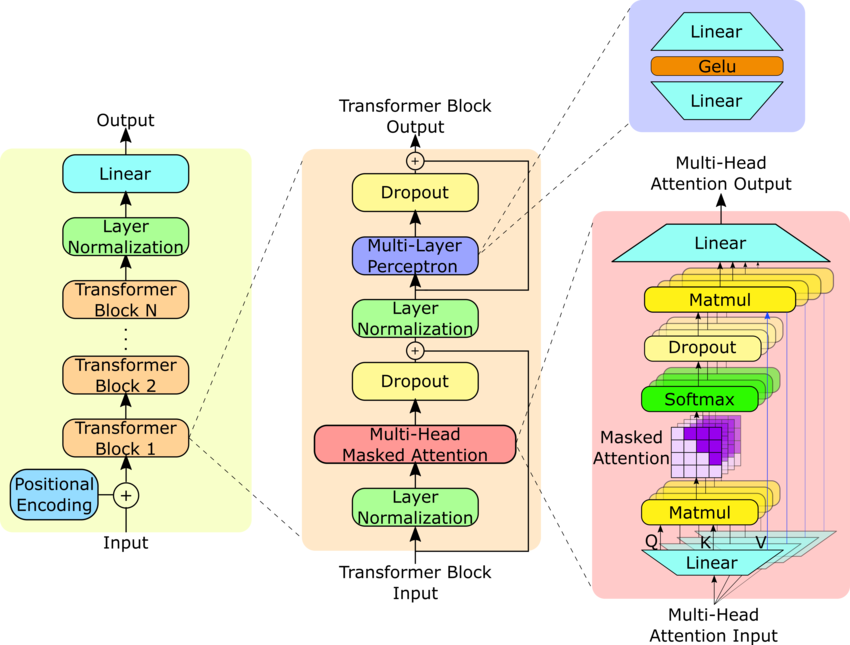

[Источник](https://www.researchgate.net/figure/GPT-2-model-architecture-The-GPT-2-model-contains-N-Transformer-decoder-blocks-as-shown_fig1_373352176?utm_source=chatgpt.com)

# 2. Частичное дообучение — заморозка слоев

In [ ]:
# заморозим все слои, кроме последнего
# это тоже не супер-быстро -- в районе полутора суток в этой среде
for name, p in model.named_parameters():
    if not name.startswith("transformer.h.11"):
        p.requires_grad = False
trainer.train()

Step,Training Loss
50,1.197000


KeyboardInterrupt: 

Почему так?

Потому что нам все еще нужно вычислять прямой проход с высокой точностью (а в прямом проходе у нас Attention-блоки -- перемножения матриц)

# 3. LoRA через PEFT

In [ ]:
from peft import LoraConfig, get_peft_model

peft_cfg = LoraConfig(task_type="CAUSAL_LM", r=8, lora_alpha=16, lora_dropout=0.05)
model = get_peft_model(model, peft_cfg)
model.print_trainable_parameters()

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
## очевидно, быстрее не стало (мы снова выполняем все прямые проходы)
trainer.train()

Step,Training Loss
50,1.171000


KeyboardInterrupt: 

Попробуем чуть по-другому

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from peft import LoraConfig, get_peft_model

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Если у токенизатора нет pad_token, добавим (GPT-2 его не имеет по умолчанию)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

# Добавляем LoRA
peft_cfg = LoraConfig(
    task_type="CAUSAL_LM",
    r=4, # LoRA представляет поправку к весам как произведение двух матриц размера (out_features × r) и (r × in_features)
    # то есть если обычная матрица весов слоя — 768×768, то LoRA с r=8 будет обучать две матрицы: 768×8 и 8×768, что в сумме значительно меньше весов
    # 768×768 vs (8+8)*768
    lora_alpha=16,
    lora_dropout=0.05,
)
model = get_peft_model(model, peft_cfg)
model.print_trainable_parameters()

ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

def tok(examples):
    # Токенизируем и создаём labels — копию input_ids для вычисления loss
    tokens = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

train_ds = ds.map(tok, batched=True, remove_columns=["text"])

training_args = TrainingArguments(
    output_dir="lora_sft"
    , num_train_epochs=3
    , per_device_train_batch_size=8
    , logging_steps=10
    , fp16=True  # mixed precision training для ускорения и экономии памяти
    , save_total_limit=1
    , save_strategy="epoch"
    , report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
)

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 147,456 || all params: 124,587,264 || trainable%: 0.1184


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
## и снова это не супербыстро
trainer.train()

Step,Training Loss
10,6.998900


KeyboardInterrupt: 

# 4. Prompt‑/Prefix‑Tuning

In [ ]:
from peft import PromptTuningConfig, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Если у токенизатора нет pad_token, добавим (GPT-2 его не имеет по умолчанию)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

prompt_cfg = PromptTuningConfig(task_type="CAUSAL_LM", num_virtual_tokens=20)

model = get_peft_model(model, peft_cfg)
model.print_trainable_parameters()

ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

def tok(examples):
    # Токенизируем и создаём labels — копию input_ids для вычисления loss
    tokens = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

train_ds = ds.map(tok, batched=True, remove_columns=["text"])

training_args = TrainingArguments(
    output_dir="prompt_tuning"
    , num_train_epochs=3
    , per_device_train_batch_size=8 # увеличить размера батча == ускорить обучение (если памяти хватает)
    , logging_steps=10
    , fp16=True  # mixed precision training для ускорения и экономии памяти
    , save_total_limit=1
    , save_strategy="epoch"
    , report_to="none"
)

trainer = Trainer(
    model=model
    , args=training_args
    , train_dataset=train_ds
)

trainable params: 147,456 || all params: 124,587,264 || trainable%: 0.1184


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Здесь мы учимся специальным «промптам» — то есть небольшой последовательности токенов (текстовых или в виде эмбеддингов), которую добавляем к входу модели.

При этом саму модель не трогаем, она заморожена.

Веса модели не меняются, а подбирается только промпт — набор дополнительных параметров.

Работает, как «внешний ключ» к модели, чтобы она лучше решала конкретную задачу.

In [ ]:
# даже так на cpu в колабе -- двое суток
trainer.train()

Step,Training Loss
10,7.031800


KeyboardInterrupt: 

Prefix-Tuning -- похожая идея, но вместо обычного текстового промпта мы учимся специальным префиксным эмбеддингам, которые добавляются на уровень внутренних слоев модели — в attention.

По сути, это дополнительный "контекст" (псевдо-токены), который вставляется в ключи и запросы (key и query) слоя трансформера.

Модель остается замороженной, а адаптируются только эти префиксные эмбеддинги.

# 5. Квантование через torch.quantization

Квантование – это метод сжатия обученной модели путём уменьшения битности весов и/или активаций . Например, перевод параметров из 16-битного float в 4- или 8-битное целое (форматы Q4, Q8) сильно сокращает объём модели и снижает требования к памяти. Обозначение qN в имени модели (q4, q8 и т.д.) указывает число бит на вес: меньше бит значит меньшая модель и более низкая точность.

Варианты q4_0 , q4_1 и пр. отличаются алгоритмом округления весов (табличное масштабирование) .


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Если у токенизатора нет pad_token, добавим (GPT-2 его не имеет по умолчанию)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")

def tok(examples):
    # Токенизируем и создаём labels — копию input_ids для вычисления loss
    tokens = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

train_ds = ds.map(tok, batched=True, remove_columns=["text"])

In [ ]:
model.cpu()
quant_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

Проверим что не сильно испортили модель, сравнив предикты квантизованной и исходной модели

In [ ]:
quant_model.eval()
inps = tokenizer("Hello world!", return_tensors="pt")
with torch.no_grad():
    out_fp = model(**inps).logits
    out_q = quant_model(**inps).logits
    top1_fp = out_fp.argmax(-1)
    top1_q = out_q.argmax(-1)

print("Predictions match:", (top1_fp == top1_q).all().item())

Predictions match: True


Для квантования есть и более релевантные инструменты:

https://github.com/AutoGPTQ/AutoGPTQ

https://github.com/bitsandbytes-foundation/bitsandbytes



# 6. GPU: Все же очень хочется какую-то модель дообучить

Ок, сменим среду выполнения на Т4

In [1]:
!pip install peft transformers datasets accelerate evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.3 MB/s eta 0:00:00


In [2]:
!pip install -U datasets huggingface_hub fsspec==2024.3.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 20.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.3.1 which is incompatible.


In [ ]:
! pip install --upgrade transformers -q

In [79]:
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2Model
from peft import get_peft_model, PromptTuningConfig, TaskType
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [80]:
# imdb -- отзывы на фильмы
dataset = load_dataset("imdb", split="train[:20_000]")  # 20_000 примеров для скорости
texts = dataset["text"]
labels = dataset["label"]  # 1=positive, 0=negative

In [81]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)
print(f"Примеры данных:\nPositive: {train_texts[0][:100]}...\nNegative: {train_texts[1][:100]}...\n")

Примеры данных:
Positive: What is it with Americans and their hang-up with religious gobbledy-gook? To think this was a best-s...
Negative: For most younger viewers out there, they probably have no idea who Buster Keaton was. So, because of...



In [82]:
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

class GPT2ForBinaryClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.gpt2 = GPT2Model.from_pretrained("gpt2")
        self.classifier = nn.Linear(self.gpt2.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        # Переносим все на нужное устройство
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, -1, :]  # Берем последний токен
        logits = self.classifier(pooled_output)
        return logits.squeeze(-1)

model = GPT2ForBinaryClassification().to(device)

In [83]:
def evaluate(model, tokenizer, texts, labels, batch_size=8):
    model.eval()
    correct = 0
    total = 0

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_labels = torch.tensor(labels[i:i+batch_size]).to(device)

        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            logits = model(inputs["input_ids"], inputs["attention_mask"])
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds == batch_labels).sum().item()
            total += len(batch_labels)

    return correct / total

In [84]:
base_acc = evaluate(model, tokenizer, test_texts[:500], test_labels[:500])
print(f"Accuracy до обучения на 500 сэмплах: {base_acc:.2f}\n")

Accuracy до обучения на 500 сэмплах: 0.62



In [85]:
# Prompt Tuning
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    num_virtual_tokens=10, # можно попробовать увеличить чтобы модель лучше училась
    token_dim=model.gpt2.config.hidden_size,
)
model.gpt2 = get_peft_model(model.gpt2, peft_config).to(device)
model.gpt2.print_trainable_parameters()

trainable params: 7,680 || all params: 124,447,488 || trainable%: 0.0062


In [86]:
# примерно полчаса
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

train_dataset = list(zip(train_texts, train_labels))
test_dataset = list(zip(test_texts, test_labels))

for epoch in range(3):
    model.train()
    total_loss = 0

    for text, label in tqdm(train_dataset, desc=f"Эпоха {epoch+1}"):
        inputs = tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        label_tensor = torch.tensor([label], dtype=torch.float).to(device)

        optimizer.zero_grad()
        logits = model(inputs["input_ids"], inputs["attention_mask"])
        loss = criterion(logits, label_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataset)
    val_acc = evaluate(model, tokenizer, [x[0] for x in test_dataset], [x[1] for x in test_dataset])
    print(f"Эпоха {epoch+1}, Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.2f}")

Эпоха 1: 100%|██████████| 16000/16000 [10:38<00:00, 25.05it/s]


Эпоха 1, Loss: 0.5385, Val Accuracy: 0.65


Эпоха 2: 100%|██████████| 16000/16000 [10:01<00:00, 26.62it/s]


Эпоха 2, Loss: 0.4576, Val Accuracy: 0.69


Эпоха 3: 100%|██████████| 16000/16000 [10:01<00:00, 26.59it/s]


Эпоха 3, Loss: 0.4332, Val Accuracy: 0.73


In [88]:
tuned_acc = evaluate(model, tokenizer, test_texts[:500], test_labels[:500])
print(f"Accuracy после обучения на 500 сэмплах: {tuned_acc:.2f}\n")

Accuracy после обучения на 500 сэмплах: 0.74

Accuracy после обучения на 500 сэмплах: 0.74



А до обучения было:

 Accuracy до обучения на 500 сэмплах: 0.62

Потестим руками обученную модель

In [89]:
test_cases = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
    "Terrible experience. The worst film I've seen this year with bad acting and boring story.",
    "It was okay, nothing special. Some parts were good but overall mediocre.",
    "The cinematography was stunning, though the plot was a bit predictable.",
    "I hated every minute of this movie. Complete waste of time and money."
]

# Убедимся, что модель в режиме оценки
model.eval()

for i, text in enumerate(test_cases, 1):
    # Токенизация и подготовка ввода
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    # Предсказание
    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["attention_mask"])
        prob = torch.sigmoid(logits).item()
        prediction = "POSITIVE" if prob > 0.5 else "NEGATIVE"

    # Наглядный вывод
    print(f"\nПример {i}:")
    print(f"Текст: {text[:150]}...")  # Выводим начало текста
    print(f"Предсказание: {prediction} (вероятность: {prob:.4f})")
    print("-" * 80)


Пример 1:
Текст: This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout....
Предсказание: POSITIVE (вероятность: 0.9656)
--------------------------------------------------------------------------------

Пример 2:
Текст: Terrible experience. The worst film I've seen this year with bad acting and boring story....
Предсказание: NEGATIVE (вероятность: 0.0019)
--------------------------------------------------------------------------------

Пример 3:
Текст: It was okay, nothing special. Some parts were good but overall mediocre....
Предсказание: NEGATIVE (вероятность: 0.0017)
--------------------------------------------------------------------------------

Пример 4:
Текст: The cinematography was stunning, though the plot was a bit predictable....
Предсказание: NEGATIVE (вероятность: 0.2549)
--------------------------------------------------------------------------------

Пример 5:
Текст: I hated every minute of this movie. Complete waste of time 

# 7. Дистилляция

Дистилляция модели — это метод сжатия нейросетей, при котором большая, мощная модель (teacher) обучает меньшую, более компактную модель (student), передавая ей знания.

Вместо обычных меток, student-модель обучается на логитах или soft labels teacher-модели, что позволяет ей "перенять" поведение более крупной сети.

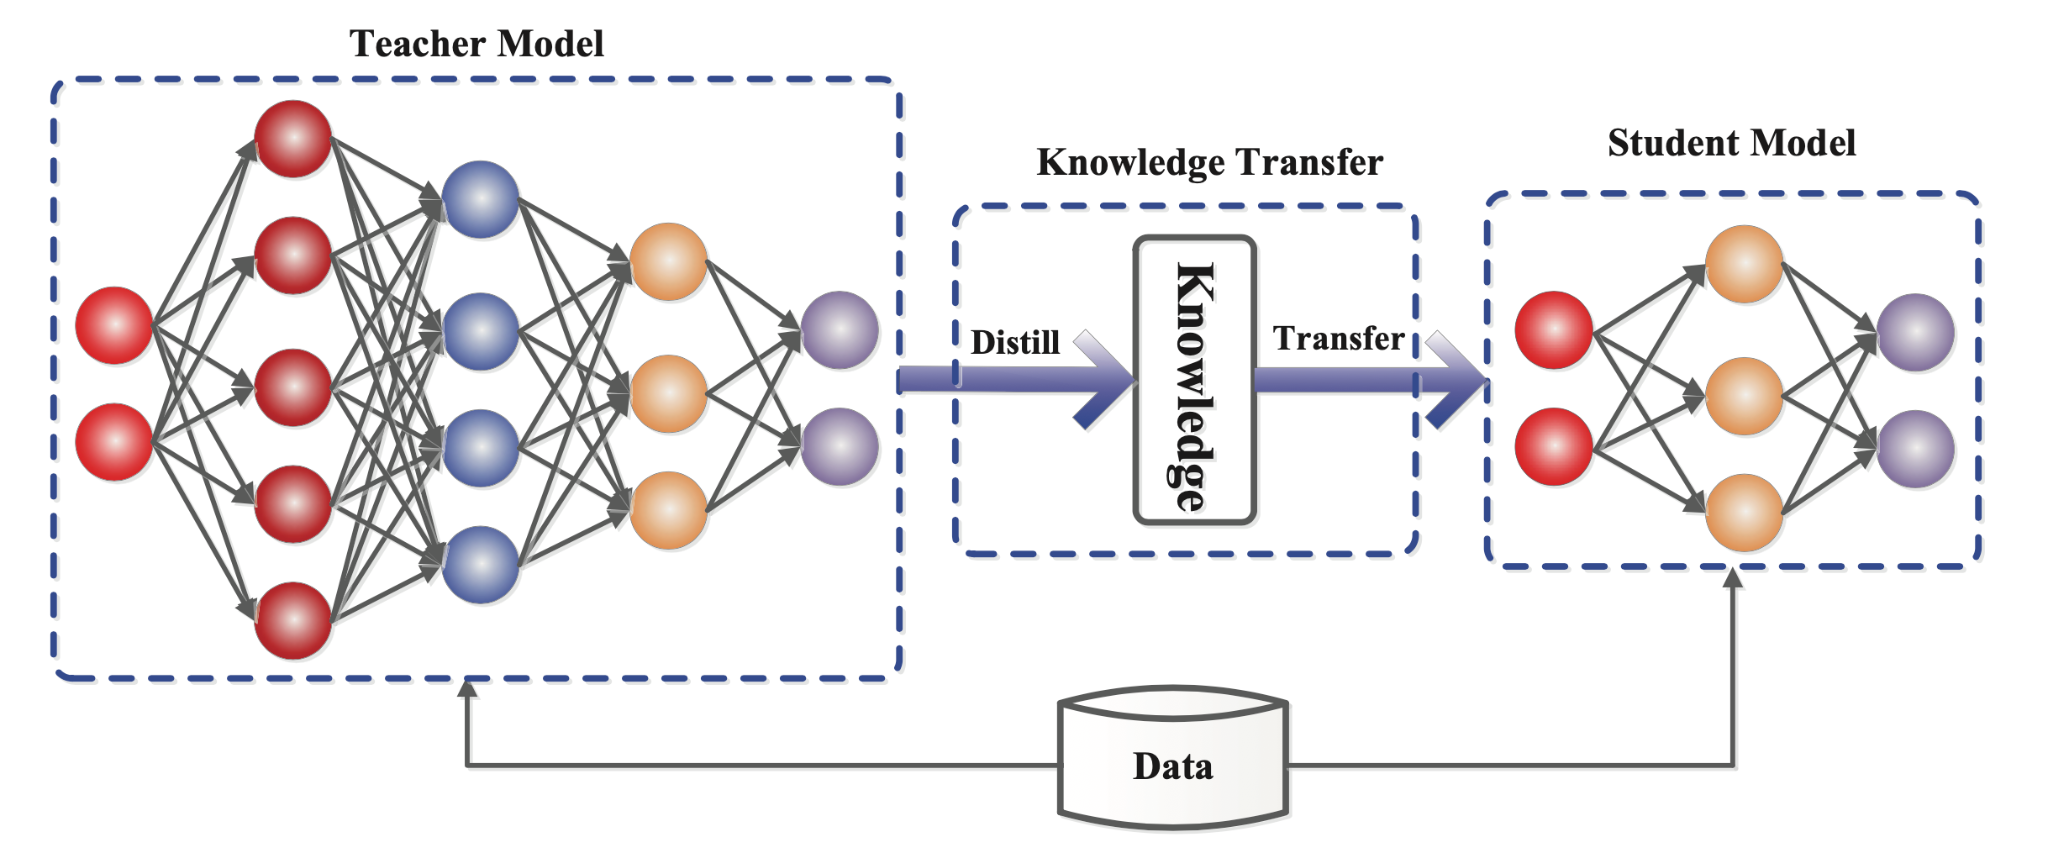

[Источник](hhttps://www.researchgate.net/publication/391196570_Compressing_Large_Language_Models_LLMs_using_Knowledge_Distillation_for_Optimizing_Inference_Time_and_Model_Size/figures?lo=1&utm_source=google&utm_medium=organic)

Для самостоятельного чтения

https://arxiv.org/pdf/1503.02531

# 8. Выводы

Дообучение LLM -- трудоемкая процедура, технически есть много вариантов реализации:

SFT:
*   Полностью (обвноляются все веса слоев)
*   Частично заморозив модель (обновляется часть слоев)

PEFT:
*   LoRA (модель заморожена, добавляем маленькие обучаемые матрицы весов)
*   Prompt-tuning (модель заморожена, обучаем спец. токены, которые добавляются к промпту)    
*   Prefix-tuning (модель заморожена, обучаем эмбеддинги фиксированной длины, которые добавляются к входной последовательности)  

Плюсы PEFT:
*   меньше шансов словить галлюцинации -- тк не меняем веса исходной модели
*   несколько меньше времени на обучение

При дообучении моделей неплохо контролировать качество не только на тесте для новой задачи, но и на открытых датасетах и на датасетах из других задач.

Также вы познакомились с методами снижения размера моделей -- квантизацией и дистилляцией, теперь у нас с вами есть база для использования LLM в агентах
